In [232]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when,round, expr
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Problem Statement 4: Customer Interaction Effectiveness

**Objective**: Assess the effectiveness of various customer interaction methods in resolving issues.

**Description:**
1.	Evaluate interactions.csv to analyse resolution rates of different interaction types (e.g., Email, Chat).
2.	Cross-reference with customers.csv to identify if specific customer demographics show a preference for certain interaction types.

**Expected Deliverables:**
- A report on interaction type effectiveness, including resolution rates and preferred interaction methods by customer demographic.
- Recommendations for improving customer support.


In [233]:
%run utilities/world_map_plot.ipynb
%run utilities/bar_plot_with_line.ipynb

In [234]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Interaction Analysis") \
    .getOrCreate()
# Load the datasets
interactions = spark.read.csv('Cleaned_data/cleaned_interactions.csv', header=True, inferSchema=True)
customers = spark.read.csv('Cleaned_data/cleaned_customers.csv', header=True, inferSchema=True)

In [235]:
# Merge interactions with customers on Customer_ID
interactions_with_customers = interactions.join(customers, on='Customer_ID')

# Group by country and interaction type, and count the occurrences
interaction_counts = interactions_with_customers.groupBy('Country', 'Interaction_Type').count()
interaction_counts = interaction_counts.groupBy('Country').pivot('Interaction_Type').sum('count').fillna(0)

# Analyzing Resolution Rates of Different Interaction Types

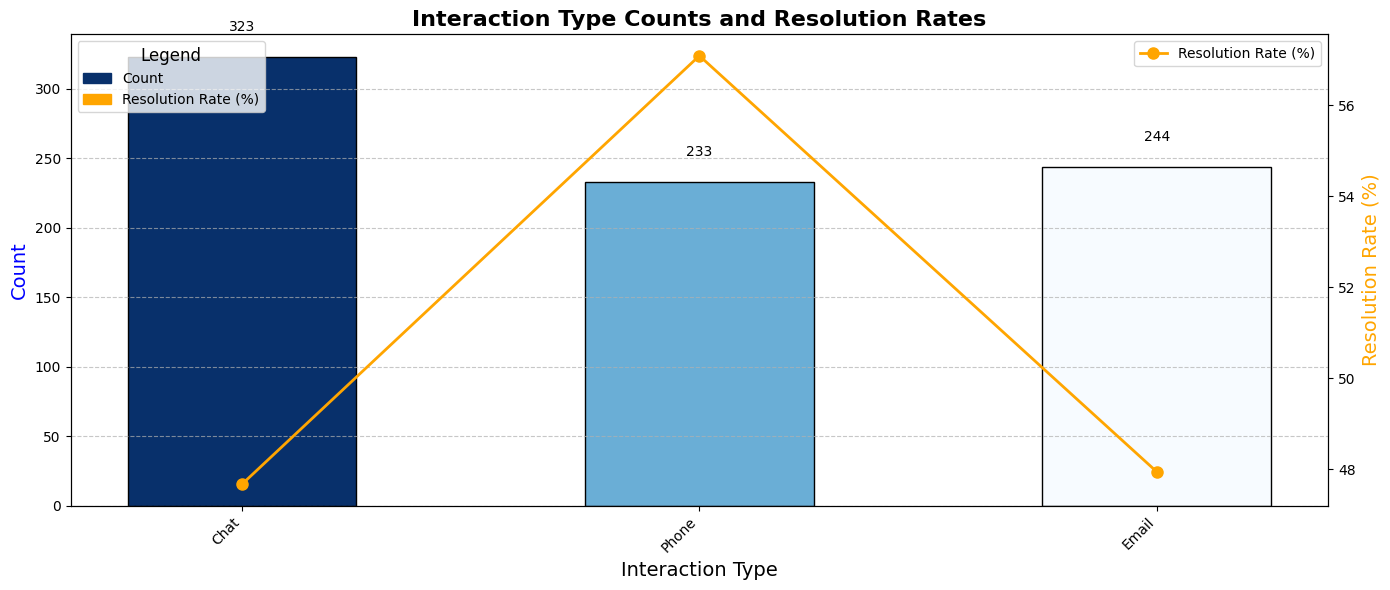

In [236]:

# Step 1: Calculate counts of interactions by type
interaction_counts = interactions_with_customers.groupBy('Interaction_Type').count()

# Step 2: Calculate resolution rates by interaction type (as percentages)
resolution_rates = interactions_with_customers.groupBy('Interaction_Type').agg(
    (F.mean(F.col('Issue_Resolved').cast('double')) * 100).alias('Resolution Rate (%)')
)

# Step 3: Combine counts and resolution rates into a single DataFrame
data = interaction_counts.join(resolution_rates, on='Interaction_Type')

# Step 4: Convert to Pandas DataFrame for plotting (if needed)
data_pd = data.toPandas()

plot_dual_axis_bar_line(
    data_pd=data_pd, 
    x_labels='Interaction_Type', 
    bar_col='count', 
    line_col='Resolution Rate (%)', 
    bar_label='Count', 
    line_label='Resolution Rate (%)', 
    title='Interaction Type Counts and Resolution Rates', 
    x_title='Interaction Type', 
    bar_y_title='Count', 
    line_y_title='Resolution Rate (%)'
)


# Top 20 Countries Based on Interaction Type Count

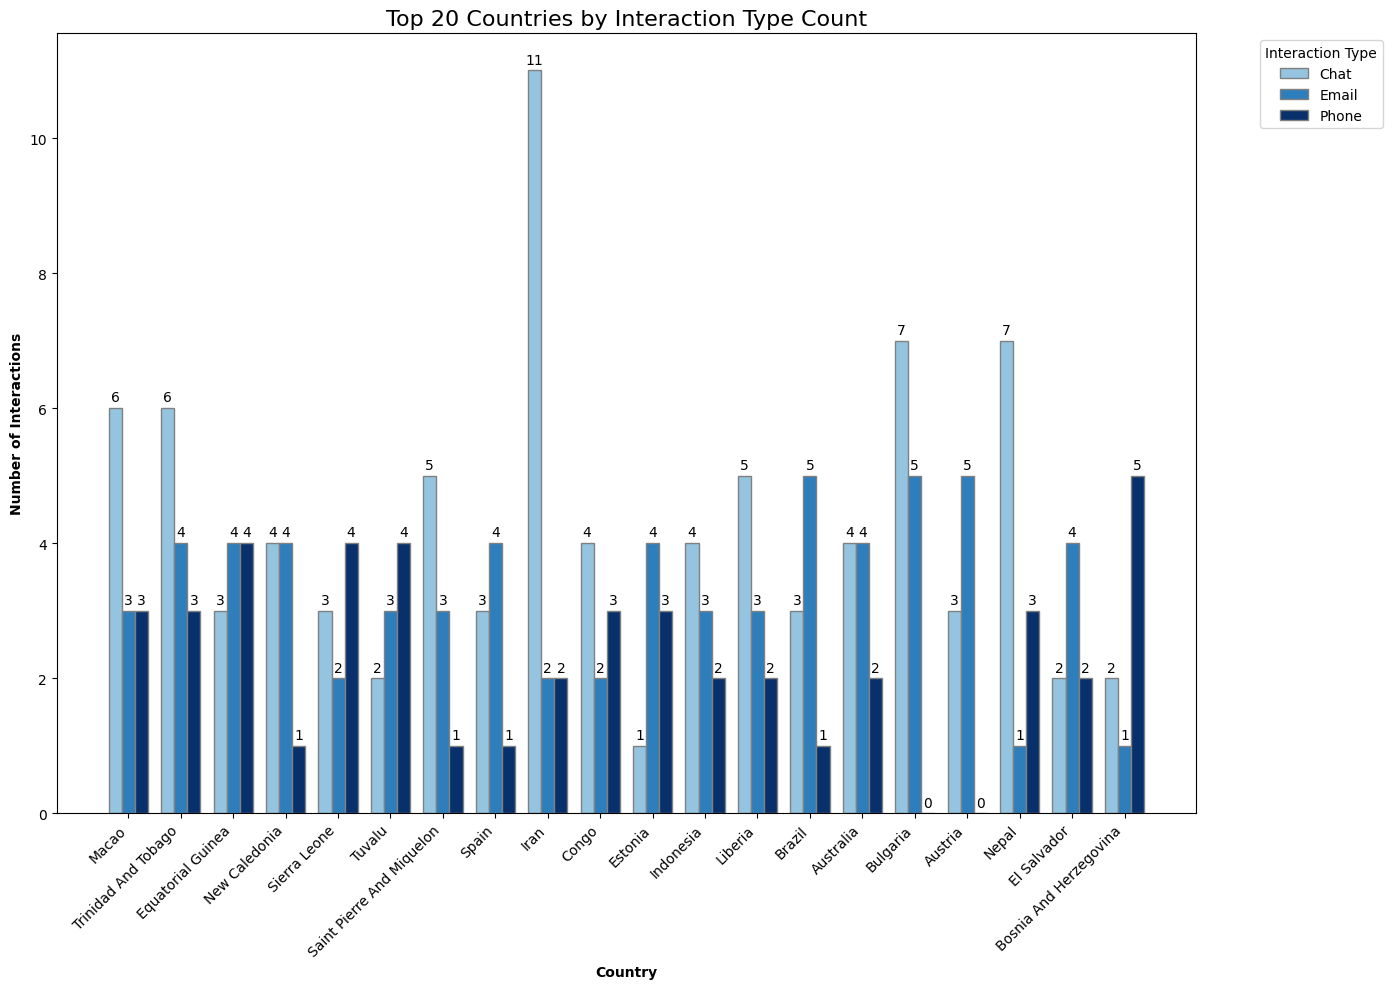

In [237]:
# Convert 'Issue_Resolved' to boolean in PySpark DataFrame
interactions = interactions.withColumn('Issue_Resolved', col('Issue_Resolved').cast('boolean'))

# Merge interactions with customers data (both should be PySpark DataFrames)
interactions_with_customers = interactions.join(customers, on='Customer_ID')

# Step 2: Count total interactions by country in PySpark DataFrame
total_interactions_by_country = interactions_with_customers.groupBy('Country').count()
total_interactions_by_country = total_interactions_by_country.withColumnRenamed('count', 'Total_Interactions')

# Step 3: Sort and get top 20 countries
top_20_countries = total_interactions_by_country.orderBy(col('Total_Interactions').desc()).limit(20)
top_20_countries_list = [row['Country'] for row in top_20_countries.collect()]

# Step 4: Filter interactions for top 20 countries
interaction_counts_top_20 = interactions_with_customers.filter(col('Country').isin(top_20_countries_list))

# Step 5: Count interactions by country and interaction type in PySpark DataFrame
interaction_counts = interaction_counts_top_20.groupBy('Country', 'Interaction_Type').count()
interaction_counts_pivot = interaction_counts.groupBy('Country').pivot('Interaction_Type').sum('count').fillna(0)

# Step 6: Convert the PySpark DataFrame to Pandas DataFrame for plotting
data = interaction_counts_pivot.toPandas()

# Step 7: Set up the data for plotting using Pandas
data.set_index('Country', inplace=True)
# Assuming 'data' is the Pandas DataFrame obtained from Spark DataFrame conversion and processing
plot_interaction_counts_by_country(data)


# Preferred Method of Interactions by Country

In [240]:
# Merge interactions with customers on Customer_ID
merged_data = interactions.join(customers, on='Customer_ID')
interaction_counts = merged_data.groupBy('Country', 'Interaction_Type').count()

pivoted_data = interaction_counts.groupBy('Country').pivot('Interaction_Type').sum('count').fillna(0)

# Define a list of interaction types (update based on your actual data)
interaction_types = ['Chat', 'Email', 'Phone']

# Create a new column for the preferred interaction method
# Use the greatest function to find the interaction type with the highest count
preferred_method = pivoted_data.withColumn(
    "Preferred_Interaction_Method", 
    expr(f"CASE " + " ".join([f"WHEN {col} = greatest({', '.join(interaction_types)}) THEN '{col}'" for col in interaction_types]) + " END")
)

# Select only the necessary columns
preferred_method = preferred_method.select('Country', 'Preferred_Interaction_Method')

# Show the top rows
preferred_method.show(5)

preferred_method_fig = plot_world_map(
    preferred_method, 
    locations_col="Country", 
    color_col="Preferred_Interaction_Method", 
    plot_title="Preferred Interaction Methods by Demographics", 
    hover_data=None, 
    is_discrete=True, 
    color_discrete_sequence=px.colors.sequential.Blues_r
)
preferred_method_fig.show()


+--------+----------------------------+
| Country|Preferred_Interaction_Method|
+--------+----------------------------+
|    Chad|                        Chat|
|Paraguay|                        Chat|
|   Macao|                        Chat|
|   Yemen|                       Email|
| Senegal|                       Email|
+--------+----------------------------+
only showing top 5 rows



24/09/06 12:48:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 4367418 ms exceeds timeout 120000 ms
24/09/06 12:48:24 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/06 12:48:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

# Resolution Rate by Country

In [239]:
# Group by country and interaction type to get total and resolved issues
country_resolution_counts = interactions_with_customers.groupBy("Country").agg(
    count(when(col("Issue_Resolved") == "Yes", 1)).alias("Resolved_Issues"),
    count("*").alias("Total_Issues")
)
# Calculate resolution rate for each country
country_resolution_rates = country_resolution_counts.withColumn(
    "Resolution_Rate", round(col("Resolved_Issues") / col("Total_Issues") * 100, 2)
)
# Show results
country_resolution_rates.show(5)
# Convert Spark DataFrame to Pandas DataFrame
country_resolution_rates_pd = country_resolution_rates.toPandas()
resolution_rate_fig = plot_world_map(
    country_resolution_rates_pd, 
    locations_col="Country", 
    color_col="Resolution_Rate", 
    plot_title="Resolution Rate by Country", 
    hover_data=["Resolved_Issues", "Total_Issues"], 
    is_discrete=False, 
    color_scale=px.colors.sequential.Blues
)
resolution_rate_fig.show()

+--------+---------------+------------+---------------+
| Country|Resolved_Issues|Total_Issues|Resolution_Rate|
+--------+---------------+------------+---------------+
|    Chad|              3|           7|          42.86|
|Paraguay|              0|           1|            0.0|
|   Macao|              7|          12|          58.33|
|   Yemen|              3|           4|           75.0|
| Senegal|              3|           6|           50.0|
+--------+---------------+------------+---------------+
only showing top 5 rows

